In [1]:
import numpy as np
import matplotlib.pyplot as plt

def wigner_function(state, x, y):
    """
    Calculate the Wigner function for a given quantum state.
    
    Parameters:
    state: np.ndarray - Density matrix of the quantum state.
    x: np.ndarray - X-axis points.
    y: np.ndarray - Y-axis points.
    
    Returns:
    np.ndarray - Wigner function values.
    """
    W = np.zeros((len(x), len(y)), dtype=np.complex128)

    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            # Calculate the Wigner function using the density matrix
            for m in range(state.shape[0]):
                for n in range(state.shape[0]):
                    W[i, j] += state[m, n] * np.exp(-2j * (xi * (m - n) + yj * (m + n)))
                    
    return W / (2 * np.pi)

def random_pure_state(d):
    """
    Generate a random pure state in d-dimensional Hilbert space.
    
    Parameters:
    d: int - Dimension of the Hilbert space.
    
    Returns:
    np.ndarray - Random pure state (density matrix).
    """
    # Generate a random vector on the complex sphere (for pure state)
    theta = np.random.rand() * np.pi
    phi = np.random.rand() * 2 * np.pi
    
    state = np.zeros((d,), dtype=np.complex128)
    state[0] = np.cos(theta)
    state[1:] = np.sin(theta) * np.exp(1j * phi * np.arange(1, d))
    
    # Normalize
    return np.outer(state, np.conjugate(state))

def generate_wigner_distributions(num_states, d, num_points):
    """
    Generate Wigner distributions for a number of random quantum states.
    
    Parameters:
    num_states: int - Number of states to generate.
    d: int - Dimension of the Hilbert space.
    num_points: int - Number of points in each direction.
    
    Returns:
    List[np.ndarray] - List of Wigner functions.
    """
    x = np.linspace(-5, 5, num_points)
    y = np.linspace(-5, 5, num_points)
    
    wigner_distributions = []
    
    for _ in range(num_states):
        state = random_pure_state(d)
        W = wigner_function(state, x, y)
        wigner_distributions.append(np.real(W))  # Only real part for visualization and loss computation
    
    return wigner_distributions


MMD Value between two sets of Wigner distributions: 0.6323


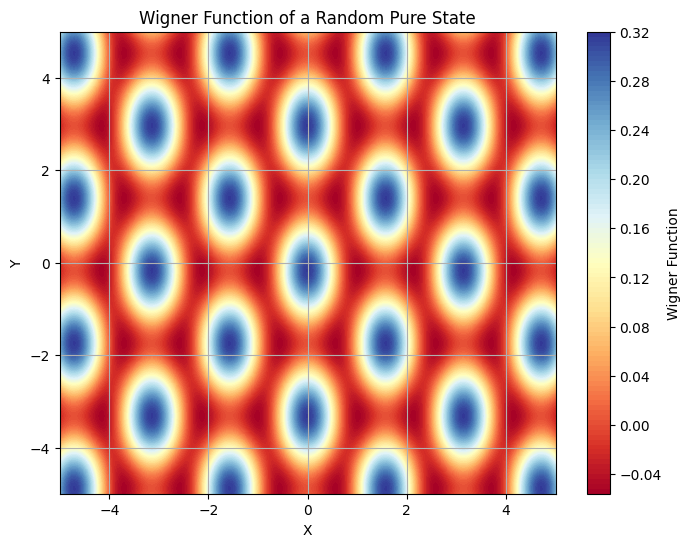

In [2]:
# Example usage
num_states = 5  # Number of random states
d = 2  # Dimension of Hilbert space (e.g., qubit)
num_points = 200  # Number of points in each direction

# Generate Wigner distributions
X = generate_wigner_distributions(num_states, d, num_points)
Y = generate_wigner_distributions(num_states, d, num_points)

from qcbm.mmd import mmd_loss

# Calculate MMD loss

XX = [x.flatten() for x in X]
YY = [y.flatten() for y in Y]

mmd_value = mmd_loss(1.0, XX, YY)
print(f"MMD Value between two sets of Wigner distributions: {mmd_value:.4f}")

# Optional: Visualizing one of the Wigner functions
plt.figure(figsize=(8, 6))
plt.contourf(np.linspace(-5, 5, num_points), np.linspace(-5, 5, num_points), X[0], levels=100, cmap='RdYlBu')
plt.colorbar(label='Wigner Function')
plt.title('Wigner Function of a Random Pure State')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [25]:
import qcbm.circuit as circ
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp


arr = np.array([[0, 1, 0], [0, 1, 1], [1, 1, 1]])
n=3

pairs = circ.get_entangled_pairs(arr)

# Target states 
arr = SparsePauliOp.from_list(
    [
        ("ZIZ", 2.302),  # Projects onto |010⟩
        ("ZZI", 1.609),  # Projects onto |011⟩
        ("ZZZ", 0.357),  # Projects onto |111⟩
    ]
)

qcbm = EfficientSU2(n, entanglement=pairs, reps=3, flatten=True)
qcbm.draw(output='mpl')
arr.num_qubits


3

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

IBM_QUANTUM_API_TOKEN = "883f28dcfedddfe625494272d0082796d75667719b65e6de7b9252ea56b289ab961e96d04c3121892bbe5d4ada1a06dc77a5e7d4acf9a866b9188d0cfcbc00be"
try:
  QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBM_QUANTUM_API_TOKEN)
except Exception as e:
  print(e)


'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'


In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

In [27]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import AerSimulator


backend = AerSimulator()
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qcbm_isa = pm.run(qcbm)

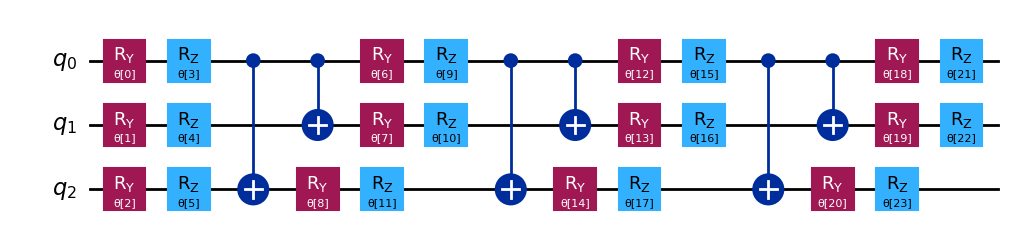

In [28]:
qcbm_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [29]:
qcbm.num_parameters

24

In [30]:
x0 = 2 * np.pi * np.random.random(qcbm.num_parameters)

pi = arr
pi_probs = np.array([0.1, 0.2, 0.7])
arr

SparsePauliOp(['ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[2.302+0.j, 1.609+0.j, 0.357+0.j])

In [118]:
cost_history_dict = {
}
cost_history_dict = {
    "prev_vector": [],
    "cost_history": [],
    "iters": 0,
}
hamiltonian_isa = arr.apply_layout(layout=qcbm_isa.layout)

In [119]:
def cost_func(params, ansatz, hamiltonian, sampler):
    
    pub = (ansatz, [hamiltonian], [params])
    result = sampler.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy    


In [120]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import EstimatorV2, Session
from qiskit_ibm_runtime import Sampler
from qiskit.primitives import StatevectorSampler

from qcbm.mmd import mmd_loss

with Session(backend=backend) as session:
    sampler = Estimator(mode=session)
    sampler.options.default_shots = 10000
    
    x0 = np.random.rand(qcbm.num_parameters)

    res = minimize(
        cost_func,
        x0, 
        args=(qcbm_isa, hamiltonian_isa, sampler),  
        method="COBYLA", 
    )

Iters. done: 1 [Current cost: -0.39132579999999995]
Iters. done: 2 [Current cost: 0.3148282]
Iters. done: 3 [Current cost: -0.49497399999999997]
Iters. done: 4 [Current cost: -0.8694426]
Iters. done: 5 [Current cost: -1.0251762]
Iters. done: 6 [Current cost: -1.6445277999999997]
Iters. done: 7 [Current cost: 0.46268679999999995]
Iters. done: 8 [Current cost: -1.6231738000000002]
Iters. done: 9 [Current cost: -1.2344074]
Iters. done: 10 [Current cost: -0.9114701999999999]
Iters. done: 11 [Current cost: -1.3610931999999998]
Iters. done: 12 [Current cost: -1.5022676000000001]
Iters. done: 13 [Current cost: 0.5127048000000001]
Iters. done: 14 [Current cost: -1.9528149999999997]
Iters. done: 15 [Current cost: -1.8071814]
Iters. done: 16 [Current cost: -1.3441404000000001]
Iters. done: 17 [Current cost: -1.818005]
Iters. done: 18 [Current cost: -1.8518834]
Iters. done: 19 [Current cost: -1.4342046]
Iters. done: 20 [Current cost: -1.9916566000000002]
Iters. done: 21 [Current cost: -1.8526922]

In [121]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [122]:
cost_history_dict["iters"] == res.nfev

True

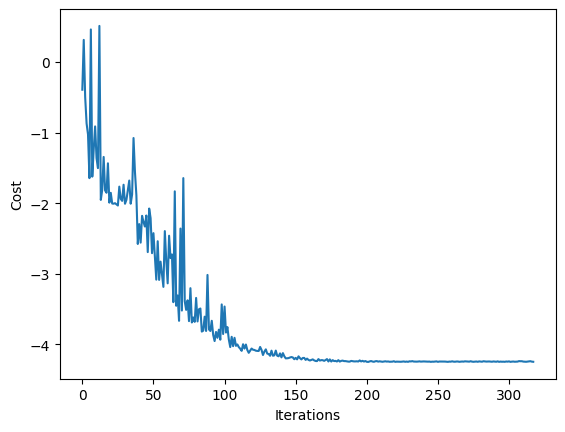

In [123]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

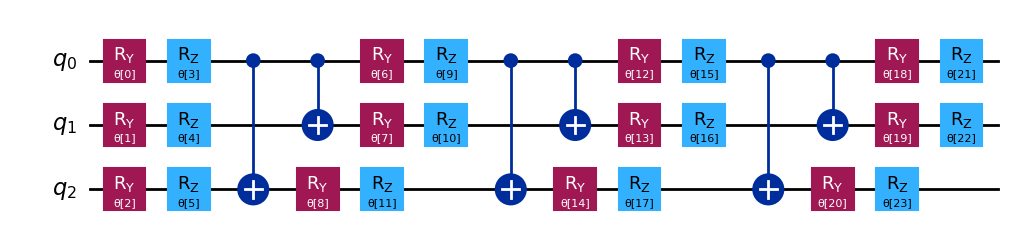

In [124]:
qcbm_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [125]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_aer.primitives import Sampler
 
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import transpile 

from qiskit_aer import AerSimulator

qc = qcbm_isa.assign_parameters(res.x)
qc_compiled = transpile(qc, backend)

In [126]:
qc.measure_all()
quasi_dists = Sampler().run(qc, shots=1000).result().quasi_dists[0]
print(quasi_dists)

{5: 0.001, 3: 0.015, 1: 0.005, 4: 0.979}


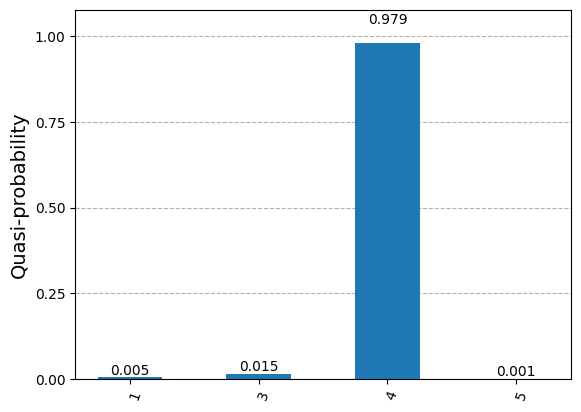

In [127]:
plot_histogram(quasi_dists)


SparsePauliOp(['ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[2.302+0.j, 1.609+0.j, 0.357+0.j])

In [137]:
observables_labels = ["ZIZ", "ZZI", "ZZZ"]

session = Session(backend=backend)

result = Estimator().run([qc]*3, arr).result()
print(result)
 
# Plot using Matplotlib
from matplotlib import pyplot as plt
plt.bar(observables_labels, result.values)

SamplerResult(quasi_dists=[{1: 0.00390625, 6: 0.00390625, 3: 0.0166015625, 4: 0.9755859375}], metadata=[{'shots': 1024, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000242625, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.000940625, 'measure_sampling': True, 'num_clbits': 3, 'max_memory_mb': 16384, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'enabled': True, 'threshold': 14, 'applied': False, 'max_fused_qubits': 5}}}])


AttributeError: 'SamplerResult' object has no attribute 'values'